[<-- retour à l'index](../index.ipynb)

# Moyennes climatiques aux échelles annuelle, saisonnières et mensuelles pour la réanalyse ERA5 
Auteur: Martin Leduc  
Date: Octobre 2024

**Description**  
Moyennes climatiques de la température calculées à partir de la réanalyse ERA5 sur la période de référence 1991-2020 pour le domaine de l'est de l'Amérique du Nord. La moyenne de 30 ans est calculée pour les échelles temporelles annuelle, saisonnière et mensuelle.  

© Copyright Ouranos Inc. and Martin Leduc 2024
This work is licensed under [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Imports
import warnings
import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import xarray as xr
import xclim
from clisops.core import subset
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

In [2]:
# Charger les données
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5_NAM.ncml"
ds = xr.open_dataset(url, chunks={"time": -1, "lat": 50, "lon": 50})
display(ds)

<xarray.Dataset> Size: 116GB
Dimensions:  (lat: 320, lon: 680, time: 26571)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.25 10.5 10.75 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float32 3kB -179.9 -179.6 -179.4 ... -10.65 -10.4 -10.15
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
Data variables:
    tas      (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    prsn     (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.9
    cell_methods:         time: mean (interval: 1 day)
    doi:                  https://doi.org/10.24381/cds.adbb2d47
    domain:               NAM
    frequency:            day
    history:              [2022-12-22 05:12:03.164107] Converted variables an...
    ...                   ...
    institute_id:         ECMWF
    dataset_id:           ERA5
    abstract:             ERA5 provides hourly estimates of a large number of...
    dataset_description:  https://www.ecmwf.int/en/forecasts/datasets/reanaly...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Copernicus Climate Change Service (C3S) (2017): ERA...

In [3]:
# Sélectionner la période
debut,fin="1991-01-01", "2020-12-31"
tas_period = ds.tas.sel(time=slice(debut,fin))

# Sélectionner la région
lon_bnds = [-100, -50]
lat_bnds = [25, 70]

tas_region = subset.subset_bbox(tas_period, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(tas_region)

<xarray.DataArray 'tas' (time: 10958, lat: 181, lon: 200)> Size: 2GB
dask.array<getitem, shape=(10958, 181, 200), dtype=float32, chunksize=(10958, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 724B 25.0 25.25 25.5 25.75 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 800B -99.9 -99.65 -99.4 ... -50.65 -50.4 -50.15
  * time     (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
Attributes:
    long_name:          2 metre temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K
    cell_methods:       time: point
    _ChunkSizes:        [365  50  50]

## Moyenne annuelle 1991-2020

In [4]:
# Calcul de la moyenne annuelle et conversion
moy_ann = tas_region.mean(dim='time')-273.15

# Copier les attributs et mettre à jour les unités
moy_ann.attrs = tas_region.attrs.copy()
moy_ann.attrs["units"] = "°C"

#with ProgressBar():
with Client() as c:
    #display(c)    
    moy_ann.load()
#display(moy_ann)

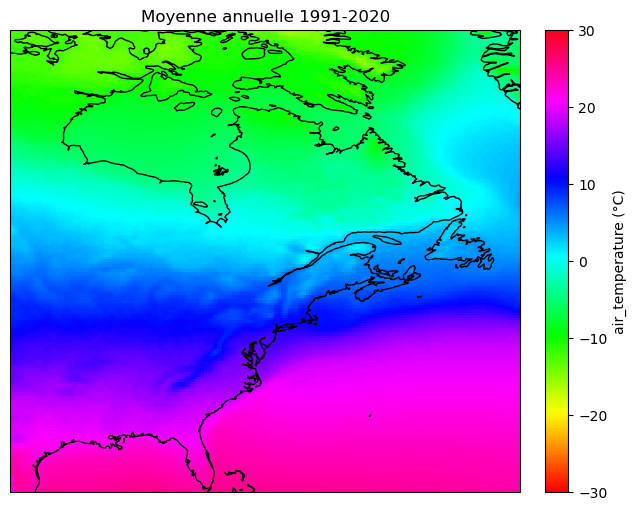

In [5]:
# Afficher carte de la moyenne annuelle

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})

# Afficher la variable
p = ax.pcolormesh(moy_ann['lon'], moy_ann['lat'], moy_ann, cmap='hsv',vmin=-30,vmax=30)

# Ajouter les lignes de côtes
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.colorbar(p,orientation="vertical", label=moy_ann.attrs["standard_name"]+" ("+moy_ann.attrs["units"]+")", fraction=0.046, pad=0.04)

# Titre
y1=str(tas_region.time.dt.year.values[0])
y2=str(tas_region.time.dt.year.values[-1])
ax.title.set_text('Moyenne annuelle '+y1+'-'+y2)

## Moyennes saisonnières 1991-2020

In [6]:
# Calcul des moyennes saisonnières et conversion
moy_saison=tas_region.groupby("time.season").mean(dim="time")-273.15

# Copier les attributs et mettre à jour les unités
moy_saison.attrs = tas_region.attrs.copy()
moy_saison.attrs["units"] = "°C"

with Client() as c:
    #display(c)
    moy_saison.load()
#display(moy_saison)

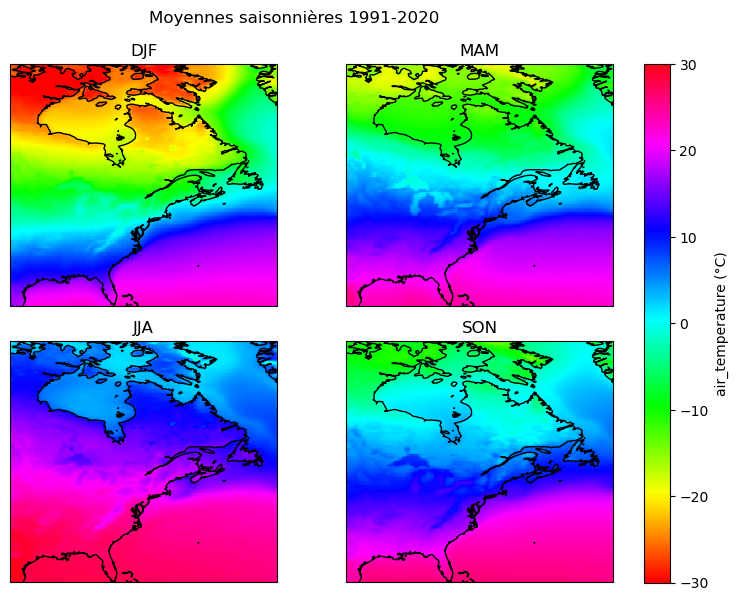

In [7]:
# Afficher les cartes saisonnières

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig,axes = plt.subplots(2,2,figsize=(8, 6), subplot_kw={'projection': projection})
axes = axes.ravel()               

seas=['DJF','MAM','JJA','SON']
for jj,sea in enumerate(seas):
    # Afficher la variable
    p=axes[jj].pcolormesh(moy_saison['lon'], moy_saison['lat'], moy_saison.sel(season=sea), cmap='hsv',vmin=-30,vmax=30)

    # Ajouter les lignes de côtes
    axes[jj].coastlines(resolution='50m', color='black', linewidth=1)
    axes[jj].title.set_text(sea)

plt.suptitle('Moyennes saisonnières '+y1+'-'+y2)
plt.tight_layout()

# Ajouter une barre de couleur globale
fig.colorbar(p, ax=axes, orientation='vertical', label=moy_saison.attrs["standard_name"]+" ("+moy_saison.attrs["units"]+")", fraction=0.046, pad=0.04)

## Moyennes mensuelles 1991-2020

In [8]:
# Calcul des moyennes mensuelles et conversion
moy_mens = tas_region.groupby('time.month').mean(dim='time')-273.15

# Copier les attributs et mettre à jour les unités
moy_mens.attrs = tas_region.attrs.copy()
moy_mens.attrs["units"] = "°C"
    
# Faire les calculs:
with Client() as c:
    #display(c)
    moy_mens.load()
#display(moy_mens)

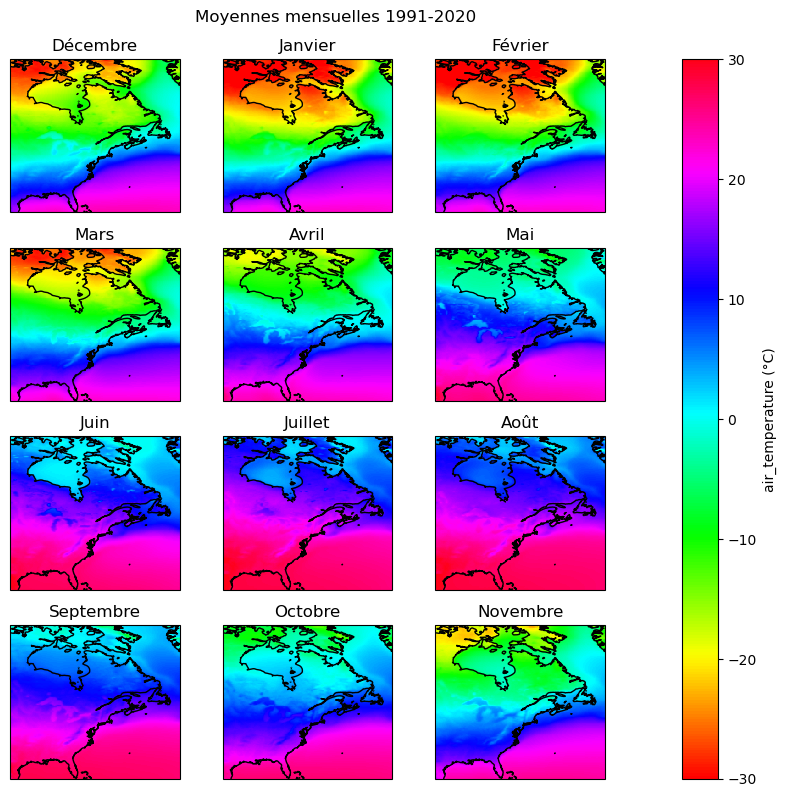

In [9]:
# Afficher les cartes mensuelles

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig,axes = plt.subplots(4,3,figsize=(8, 8), subplot_kw={'projection': projection})
axes = axes.ravel()               

#months=np.arange(12)+1
months=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
months_labels=['Décembre','Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Août','Septembre','Octobre','Novembre']
for jj,month in enumerate(months):

    # Afficher la variable
    p=axes[jj].pcolormesh(moy_mens['lon'], moy_mens['lat'], moy_mens.sel(month=month), cmap='hsv',vmin=-30,vmax=30)

    # Ajouter les lignes de côtes
    axes[jj].coastlines(resolution='50m', color='black', linewidth=1)
    
    # Titres panneaux
    axes[jj].title.set_text(months_labels[jj])

plt.suptitle('Moyennes mensuelles '+y1+'-'+y2)
plt.tight_layout()

# Ajouter une barre de couleur globale
fig.colorbar(p, ax=axes, orientation='vertical', fraction=0.05, pad=0.1, label=moy_mens.attrs["standard_name"]+" ("+moy_mens.attrs["units"]+")")